# Задача 9. Hand-crafted graph features

- Найти или сгенерировать набор данных для бинарной классификации графов.
- Реализовать функцию shortest_path_kernel(train_graphs, test_graphs), которая принимает тренировочный и тестовые наборы, а возвращает пару K_train, K_test

    - Опишите графы с помощью вектора из количества кратчайших путей различной длины
    - Для вычисления длин кратчайших путей можно использовать nx.shortest_path_length(G)
    - Ядровая функция для сравнения двух графов - скалярное произведение их двух векторов
    - K_train - матрица из ядровых функций для сравнения тренировочных графов между собой
    - K_test - матрица из ядровых функций для сравнения тестовых графов с тренировочными

- Используя реализованное ядро обучите модель SVC, подберите гиперпараметры, вычислите различные метрики качества
- (+5 баллов) Также реализовать Weisfeiler-Lehman Kernel и обучить классификатор с ним, сравнить результаты.

# Генерация данных
Создадим два класс из объединения нескольких классов графов
### Класс 0: Регулярные структуры
    - Решетки (grid graphs)
    - Полные бипартитные графы
    - Кольца (циклы с дополнительными ребрами)
### Класс 1: Случайные и scale-free структуры
    - Графы Эрдёша-Реньи (ER)
    - Графы Барабаши-Альберт (BA)
    - Графы Уоттса-Строгаца (малый мир)

In [1]:
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split

def generate_data(n_samples_per_class=50, min_nodes=10, max_nodes=50):
    graphs = []
    labels = []

    for _ in range(n_samples_per_class):
        n_nodes = np.random.randint(min_nodes, max_nodes + 1)
        graph_type = np.random.choice(['grid', 'bipartite', 'lattice'])

        if graph_type == 'grid':
            rows = int(np.sqrt(n_nodes))
            cols = n_nodes // rows
            G = nx.grid_2d_graph(rows, cols)
            G = nx.convert_node_labels_to_integers(G)
        elif graph_type == 'bipartite':
            size1 = np.random.randint(3, n_nodes-3)
            size2 = n_nodes - size1
            G = nx.complete_bipartite_graph(size1, size2)
        else:
            G = nx.cycle_graph(n_nodes)
            for i in range(n_nodes):
                if np.random.rand() > 0.7 and i+2 < n_nodes:
                    G.add_edge(i, i+2)

        graphs.append(G)
        labels.append(0)

    for _ in range(n_samples_per_class):
        n_nodes = np.random.randint(min_nodes, max_nodes + 1)
        graph_type = np.random.choice(['er', 'ba', 'ws'])

        if graph_type == 'er':
            p = min(0.2, 2.5 / n_nodes)
            G = nx.erdos_renyi_graph(n_nodes, p)
            while not nx.is_connected(G):
                p = min(1.0, p * 1.2)
                G = nx.erdos_renyi_graph(n_nodes, p)
        elif graph_type == 'ba':
            m = np.random.randint(1, 4)
            G = nx.barabasi_albert_graph(n_nodes, m)
        else:
            k = np.random.randint(3, 8)
            p = np.random.uniform(0.1, 0.3)
            G = nx.connected_watts_strogatz_graph(n_nodes, k, p)

        graphs.append(G)
        labels.append(1)

    return graphs, labels


graphs, labels = generate_data(n_samples_per_class=60)
X_train, X_test, y_train, y_test = train_test_split(graphs, labels, test_size=0.3, random_state=42)

# Shortest-Path Kernel
Ядро кратчайших путей (Shortest-Path Kernel) вычисляет для каждого графа вектор признаков, где каждый элемент соответствует количеству кратчайших путей определенной длины между всеми парами вершин.
И max_path_lenght ограничивает максимальную длину пути, которую учитываем

In [2]:
from collections import defaultdict
import numpy as np

def shortest_path_kernel(train_graphs, test_graphs, max_path_length=20):
    def compute_feature_vector(graph, max_len):
        path_lengths = []
        for node in graph.nodes():
            lengths = nx.shortest_path_length(graph, source=node)
            for _, length in lengths.items():
                if length > 0:
                    path_lengths.append(length)

        hist, _ = np.histogram(path_lengths, bins=np.arange(0.5, max_len + 1.5))
        return hist / np.sum(hist)

    all_lengths = []
    for G in train_graphs:
        for node in G.nodes():
            lengths = nx.shortest_path_length(G, source=node)
            for _, length in lengths.items():
                if length > 0:
                    all_lengths.append(length)
    max_observed = max(all_lengths) if all_lengths else 0
    max_len = min(max_observed, max_path_length)

    X_train_feat = np.array([compute_feature_vector(G, max_len) for G in train_graphs])
    X_test_feat = np.array([compute_feature_vector(G, max_len) for G in test_graphs])

    K_train = X_train_feat @ X_train_feat.T
    K_test = X_test_feat @ X_train_feat.T

    return K_train, K_test

def shortest_path_kernel(train_graphs, test_graphs, max_path_length=15):
    def compute_feature_vector(graph):
        hist = np.zeros(max_path_length + 1)
        total_pairs = 0

        for node in graph.nodes():
            try:
                lengths = nx.single_source_shortest_path_length(graph, node)
                for target, length in lengths.items():
                    if node != target and 0 < length <= max_path_length:
                        hist[length] += 1
                        total_pairs += 1
            except nx.NetworkXError:
                continue

        if total_pairs > 0:
            hist = hist / total_pairs
        return hist

    X_train_feat = np.array([compute_feature_vector(G) for G in train_graphs])
    X_test_feat = np.array([compute_feature_vector(G) for G in test_graphs])

    K_train = X_train_feat @ X_train_feat.T
    K_test = X_test_feat @ X_train_feat.T

    return K_train, K_test

In [3]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

K_train, K_test = shortest_path_kernel(X_train, X_test)

parameters = {'C': [0.1, 1, 10]}
svc = SVC(kernel='precomputed', probability=True)
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(K_train, y_train)

y_pred = clf.predict(K_test)
y_proba = clf.predict_proba(K_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {accuracy:.3f}, F1: {f1:.3f}, ROC-AUC: {roc_auc:.3f}")

Accuracy: 0.694, F1: 0.621, ROC-AUC: 0.700


# Weisfeiler–Lehman Subtree Kernel
Weisfeiler-Lehman Subtree Kernel сравнивает графы, анализируя их локальную структуру через итеративное обновление меток узлов. На каждой итерации информация о соседях агрегируется, создавая всё более детализированные структурные "отпечатки".

In [4]:
def weisfeiler_lehman_kernel(train_graphs, test_graphs, iterations=3):
    global_label_map = {}

    def wl_iteration(graph, current_labels, extend_map=True):
        new_labels = {}
        for node in graph.nodes():
            neighbor_labels = tuple(sorted(current_labels[n] for n in graph.neighbors(node)))
            new_id = (current_labels[node], neighbor_labels)

            if new_id in global_label_map:
                new_labels[node] = global_label_map[new_id]
            elif extend_map:
                new_label = len(global_label_map)
                global_label_map[new_id] = new_label
                new_labels[node] = new_label
            else:
                new_labels[node] = -1
        return new_labels

    def compute_wl_vector(graph, iterations, extend_map=True):
        current_labels = {node: graph.degree(node) for node in graph.nodes()}
        histograms = []

        labels = list(current_labels.values())
        hist_initial = np.bincount(labels, minlength=0)
        if np.sum(hist_initial) > 0:
            hist_initial = hist_initial / np.sum(hist_initial)
        histograms.append(hist_initial)

        for _ in range(iterations):
            current_labels = wl_iteration(graph, current_labels, extend_map)
            labels = list(current_labels.values())

            if not extend_map:
                labels = [l for l in labels if l != -1]

            if labels:
                hist = np.bincount(labels, minlength=0)
                if np.sum(hist) > 0:
                    hist = hist / np.sum(hist)
                histograms.append(hist)
            else:
                histograms.append(np.array([]))

        return np.concatenate(histograms)

    train_vectors = []
    for G in train_graphs:
        vec = compute_wl_vector(G, iterations, extend_map=True)
        train_vectors.append(vec)
    max_len = max(len(vec) for vec in train_vectors)

    X_train_feat = np.zeros((len(train_graphs), max_len))
    for i, vec in enumerate(train_vectors):
        if len(vec) < max_len:
            padded_vec = np.pad(vec, (0, max_len - len(vec)))
        else:
            padded_vec = vec[:max_len]
        X_train_feat[i] = padded_vec

    test_vectors = []
    for G in test_graphs:
        vec = compute_wl_vector(G, iterations, extend_map=False)
        test_vectors.append(vec)

    X_test_feat = np.zeros((len(test_graphs), max_len))
    for i, vec in enumerate(test_vectors):
        if len(vec) < max_len:
            padded_vec = np.pad(vec, (0, max_len - len(vec)))
        else:
            padded_vec = vec[:max_len]
        X_test_feat[i] = padded_vec

    K_train_wl = X_train_feat @ X_train_feat.T
    K_test_wl = X_test_feat @ X_train_feat.T

    return K_train_wl, K_test_wl

In [5]:
K_train_wl, K_test_wl = weisfeiler_lehman_kernel(X_train, X_test, iterations=3)

clf_wl = GridSearchCV(svc, parameters, cv=5)
clf_wl.fit(K_train_wl, y_train)

y_pred_wl = clf_wl.predict(K_test_wl)
y_proba_wl = clf_wl.predict_proba(K_test_wl)[:, 1]

accuracy_wl = accuracy_score(y_test, y_pred_wl)
f1_wl = f1_score(y_test, y_pred_wl)
roc_auc_wl = roc_auc_score(y_test, y_proba_wl)

print("Shortest Path Kernel Results:")
print(f"Accuracy: {accuracy:.3f}, F1: {f1:.3f}, ROC-AUC: {roc_auc:.3f}")

print("\nWeisfeiler-Lehman Kernel Results:")
print(f"Accuracy: {accuracy_wl:.3f}, F1: {f1_wl:.3f}, ROC-AUC: {roc_auc_wl:.3f}")

Shortest Path Kernel Results:
Accuracy: 0.694, F1: 0.621, ROC-AUC: 0.700

Weisfeiler-Lehman Kernel Results:
Accuracy: 0.861, F1: 0.872, ROC-AUC: 0.873


# Зависимость от длины пути в Shortest-Path Kernel

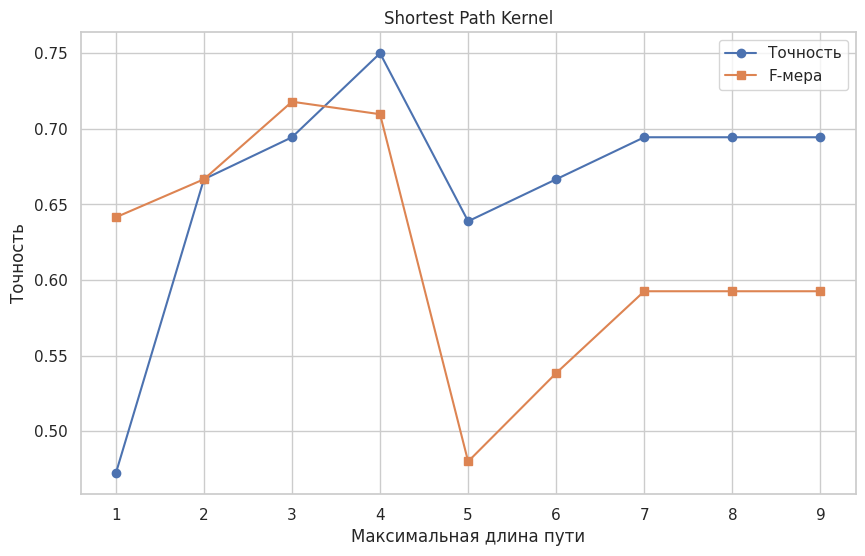

Максимальная точность: 0.75


In [15]:
path_lengths = range(1, 10, 1)
accuracies = []
f1_scores = []

for max_len in path_lengths:
    K_train_sp, K_test_sp = shortest_path_kernel(X_train, X_test, max_path_length=max_len)

    svc = SVC(kernel='precomputed', C=1, random_state=42)
    svc.fit(K_train_sp, y_train)

    y_pred = svc.predict(K_test_sp)

    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(path_lengths, accuracies, 'o-', label='Точность')
plt.plot(path_lengths, f1_scores, 's-', label='F-мера')
plt.xlabel('Максимальная длина пути')
plt.ylabel('Точность')
plt.title('Shortest Path Kernel')
plt.legend()
plt.grid(True)
plt.show()
print(f"Максимальная точность: {max(accuracies)}")

После максимальной длины пути 7 точность не меняется

# Зависимость от количества итераций в Weisfeiler-Lehman Kernel

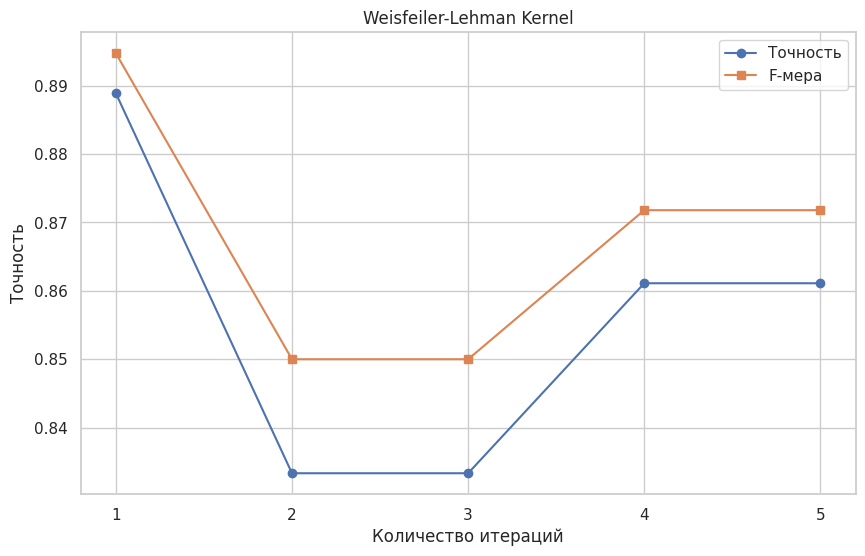

Максимальная точность: 0.8888888888888888


In [17]:
iterations = range(1, 6)
wl_accuracies = []
wl_f1_scores = []

for it in iterations:
    K_train_wl, K_test_wl = weisfeiler_lehman_kernel(X_train, X_test, iterations=it)

    svc = SVC(kernel='precomputed', C=10, random_state=42)
    svc.fit(K_train_wl, y_train)

    y_pred = svc.predict(K_test_wl)

    wl_accuracies.append(accuracy_score(y_test, y_pred))
    wl_f1_scores.append(f1_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(iterations, wl_accuracies, 'o-', label='Точность')
plt.plot(iterations, wl_f1_scores, 's-', label='F-мера')
plt.xlabel('Количество итераций')
plt.ylabel('Точность')
plt.title('Weisfeiler-Lehman Kernel')
plt.legend()
plt.grid(True)
plt.xticks(iterations)
plt.show()
print(f"Максимальная точность: {max(wl_accuracies)}")

Максимальная точность оказывается на 1 итерации, это происходит из-за сильно отличных изначальных классов, и с каждой итерацией метки узлов становятся более глобальными

# Кривые обучения

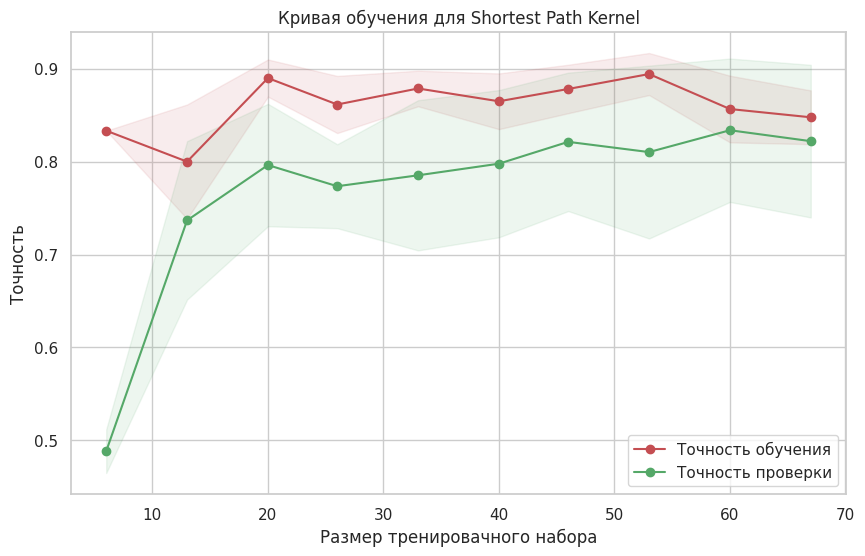

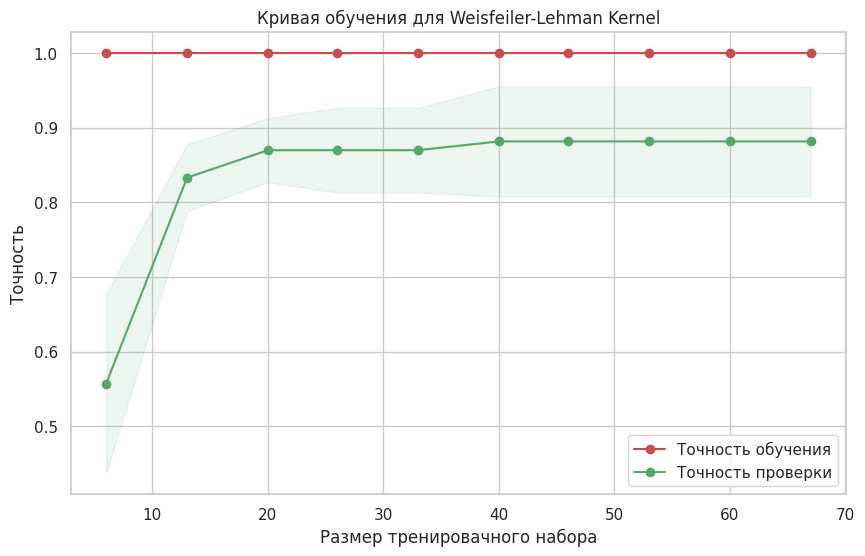

In [10]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(K_train, y_train, title):
    train_sizes, train_scores, test_scores = learning_curve(
        SVC(kernel='precomputed', C=10),
        K_train,
        y_train,
        cv=5,
        scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_mean, 'o-', color='r', label='Точность обучения')
    plt.plot(train_sizes, test_mean, 'o-', color='g', label='Точность проверки')

    plt.xlabel('Размер тренировачного набора')
    plt.ylabel('Точность')
    plt.title(f'Кривая обучения для {title}')
    plt.legend()
    plt.grid(True)
    plt.show()


K_train_sp, _ = shortest_path_kernel(X_train, X_test, max_path_length=10)
plot_learning_curve(K_train_sp, y_train, 'Shortest Path Kernel')

K_train_wl, _ = weisfeiler_lehman_kernel(X_train, X_test, iterations=3)
plot_learning_curve(K_train_wl, y_train, 'Weisfeiler-Lehman Kernel')

# Итог
У Weisfeiler-Lehman итоговая точность вышла выше, Это может быть обусловлено тем, что WL-ядро лучше улавливает структурные особенности графов через метки вершин, даже при уменьшении точности после первой итерации, учитывая локальную окрестность каждой вершины на разных уровнях.